In [1]:
import re
from io import StringIO
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Reads one block of the file, used in mdm_reader
def read_block(body):
    lines = body.strip().split("\n")
    output = StringIO()
    info=[]
    for line in lines:
        tline= line.strip()
        if tline.startswith("ICCAP_VAR") or tline.startswith("#"):
            info.append(tline)
            new_line = "%"+ tline
        else:
            
            new_line = tline
        # only write non blank lines
        if (new_line):
            output.write(new_line + '\n')
    output.seek(0)
    data = np.loadtxt(output, comments='%')
    return data,info

# Reads only a precise measurement of a file (to chose one specific Vg for instance)
# measurement_index is the place of occurence in the file
def mdm_reader_index(fname,measurement_index):
    f = open(fname, "r")    
    text = f.read()
    ldata = []
    i=0
    for begin_match, end_match in zip(re.finditer("BEGIN_DB", text), re.finditer("END_DB", text)):
        
        s = begin_match.end()
        e = end_match.start()
        body = text[s:e]
        
        if i==measurement_index:
            data,info = read_block(body)
            ldata.append(data)
        i+=1
        # convert to numpy array
    adata = np.array(ldata)
    f.close()
    return adata,info

# Reads a whole file
def mdm_reader_extract(fname):
    f = open(fname, "r")    
    text = f.read()
    ldata = []
    i=0
    for begin_match, end_match in zip(re.finditer("BEGIN_DB", text), re.finditer("END_DB", text)):
        
        s = begin_match.end()
        e = end_match.start()
        body = text[s:e]
        
       
        data,info = read_block(body)
        ldata.append(data)
        
        # convert to numpy array
    adata = np.array(ldata)
    f.close()
    return adata

### Id Vd curve

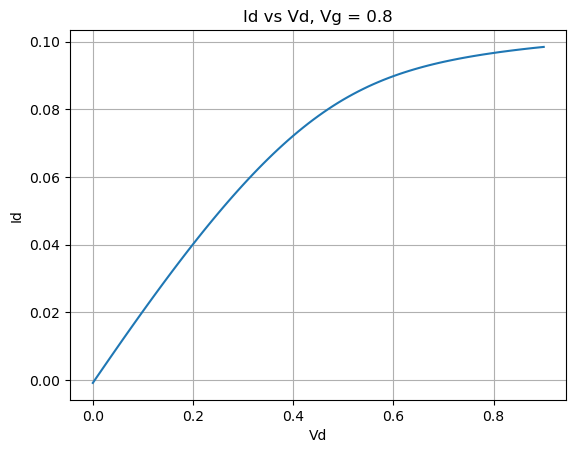

In [3]:
# SLVT stands for super low threshold voltage
# File format : Die - Type - Finger Width - Number of fingers - Vbg - IV measured - Reference voltage (Vd if Vg in IV curve and vice versa)

file1 = "../Data/1M/data_MPW2230_Die1_20200708/Die1_SLVTL20_Wf1_Nf16_vbg_0V_idvd_0p8V.mdm"

# vref should be either 'Vg' or 'Vd'                                               
def IVcurve(file, measurement_index, v_index, i_index, vref, xlabel='V', ylabel='I', title='IV Curve'):
    data, info = mdm_reader_index(file, measurement_index)
    data = data[0]

    v_ref = float(info[0].split()[-1])
    v = [column[v_index] for column in data]
    i = [column[i_index] for column in data]

    # Plot
    plt.plot(v, i, linestyle='-')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plotTitle = title + ", {} = {}".format(vref, v_ref)
    plt.title(plotTitle)
    plt.grid(True)
    #plt.show()

    # Return
    return v, i

vd, id = IVcurve(file1, 0, 0, 1, 'Vg', 'Vd', 'Id', 'Id vs Vd')

### S Parameters

In [4]:
file2 = '../Data/1M/data_MPW2230_Die1_20200708/Die1_SLVTL20_Wfp5_Nf32_vbg_0V_Spar_HF_cold_0V.mdm'

def S_parameters(file, measurement_index, norm=True, plot=False):
    data, info = mdm_reader_index(file, measurement_index)
    data = data[0]

    vd = info[0].split()[-1]
    vg = info[1].split()[-1]
    f = data[:, 0]
    # c for complex
    S11c = np.array([data[:, 3], data[:, 4]])
    S12c = np.array([data[:, 5], data[:, 6]])
    S21c = np.array([data[:, 7], data[:, 8]])
    S22c = np.array([data[:, 9], data[:, 10]])

    S11 = 20*np.log10(np.sqrt(S11c[0]**2 + S11c[1]**2))
    S12 = 20*np.log10(np.sqrt(S12c[0]**2 + S12c[1]**2))
    S21 = 20*np.log10(np.sqrt(S21c[0]**2 + S21c[1]**2))
    S22 = 20*np.log10(np.sqrt(S22c[0]**2 + S22c[1]**2))

    if plot:
        plt.plot(f*1e-9, S11, linestyle='-', label='S11')
        plt.plot(f*1e-9, S12, linestyle='-', label='S12')
        plt.plot(f*1e-9, S21, linestyle='-', label='S21')
        plt.plot(f*1e-9, S22, linestyle='-', label='S22')
        plt.xlabel('Frequency [GHz]')
        plt.ylabel('Magnitude [dB]')
        plt.title('S Parameters, Vd = {}, Vg = {}'.format(vd, vg))
        plt.grid(True)
        plt.legend()
        plt.show()
        
    if norm:
        return S11, S12, S21, S22
    else:
        return S11c[0] + 1j*S11c[1], S12c[0] + 1j*S12c[1], S21c[0] + 1j*S21c[1], S22c[0] + 1j*S22c[1]
    
    
S11, S12, S21, S22 = S_parameters(file2, 0, norm=False)
print(S11)

[ 1.00018525-8.65690131e-03j  1.00122058-1.55435102e-02j
  0.99954498-2.34982204e-02j  0.9992646 -3.22740860e-02j
  0.99890769-3.99670675e-02j  0.99847752-4.77786064e-02j
  0.99843991-5.59676476e-02j  0.99763113-6.37618825e-02j
  0.99709553-7.16697797e-02j  0.99647641-7.97800273e-02j
  0.99555397-8.75631124e-02j  0.99459356-9.58274230e-02j
  0.99395543-1.03906766e-01j  0.99291354-1.11974008e-01j
  0.99190074-1.19776763e-01j  0.9906702 -1.27655953e-01j
  0.98926926-1.35714084e-01j  0.9883275 -1.43380553e-01j
  0.98679793-1.51059449e-01j  0.98565203-1.58992350e-01j
  0.98411721-1.66556269e-01j  0.9829253 -1.74423009e-01j
  0.98116428-1.82045057e-01j  0.97955787-1.89635992e-01j
  0.97762346-1.97362334e-01j  0.976004  -2.05019712e-01j
  0.97394139-2.12892383e-01j  0.97222853-2.20339239e-01j
  0.97016841-2.28421316e-01j  0.96761268-2.36035138e-01j
  0.96591645-2.43664846e-01j  0.96325415-2.51098663e-01j
  0.96138841-2.58940279e-01j  0.95848536-2.66356766e-01j
  0.95668638-2.73624271e-01j  0

### Y and Z Parameters

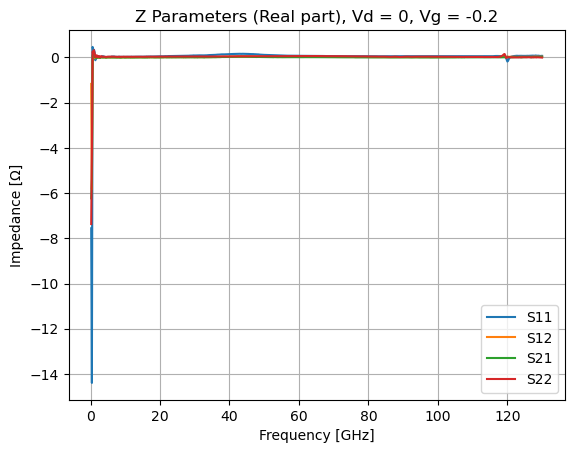

In [5]:
def Y_parameters(file, measurement_index, plot=False):
    data, info = mdm_reader_index(file, measurement_index)
    data = data[0]

    vd = info[0].split()[-1]
    vg = info[1].split()[-1]
    f = data[:, 0]
    # c for complex
    S11c = np.array([data[:, 3], data[:, 4]])
    S12c = np.array([data[:, 5], data[:, 6]])
    S21c = np.array([data[:, 7], data[:, 8]])
    S22c = np.array([data[:, 9], data[:, 10]])

    S11 = S11c[0] + 1j*S11c[1]
    S12 = S12c[0] + 1j*S12c[1]
    S21 = S21c[0] + 1j*S21c[1]
    S22 = S22c[0] + 1j*S22c[1]

    Y11 = ((1 + S22) * (1 - S11) + S12 * S21) / ((1 + S22) * (1 + S11) - S12 * S21)
    Y12 = -2*S12/((1 + S22) * (1 + S11) - S12 * S21)
    Y21 = -2*S21/((1 + S22) * (1 + S11) - S12 * S21)
    Y22 = ((1 + S11) * (1 - S22) + S12 * S21) / ((1 + S22) * (1 + S11) - S12 * S21)

    if plot:
        plt.plot(f*1e-9, np.real(Y11), linestyle='-', label='S11')
        plt.plot(f*1e-9, np.real(Y12), linestyle='-', label='S12')
        plt.plot(f*1e-9, np.real(Y21), linestyle='-', label='S21')
        plt.plot(f*1e-9, np.real(Y22), linestyle='-', label='S22')
        plt.xlabel('Frequency [GHz]')
        plt.ylabel('Admittance [S]')
        plt.title('Y Parameters (Real part), Vd = {}, Vg = {}'.format(vd, vg))
        plt.grid(True)
        plt.legend()
        plt.show()
        
    return Y11, Y12, Y21, Y22

Y11, Y12, Y21, Y22 = Y_parameters(file2, 0)


# Scale sucks for this one
def Z_parameters(file, measurement_index, plot=False):
    data, info = mdm_reader_index(file, measurement_index)
    data = data[0]

    vd = info[0].split()[-1]
    vg = info[1].split()[-1]
    f = data[:, 0]
    # c for complex
    S11c = np.array([data[:, 3], data[:, 4]])
    S12c = np.array([data[:, 5], data[:, 6]])
    S21c = np.array([data[:, 7], data[:, 8]])
    S22c = np.array([data[:, 9], data[:, 10]])

    S11 = S11c[0] + 1j*S11c[1]
    S12 = S12c[0] + 1j*S12c[1]
    S21 = S21c[0] + 1j*S21c[1]
    S22 = S22c[0] + 1j*S22c[1]

    Z11 = ((1 + S11) * (1 - S22) + S12 * S21) / ((1 -S11) * (1 - S22) - S12 * S21)
    Z12 = 2*S12/((1 - S11) * (1 -S22) - S12 * S21)
    Z21 = 2*S21/((1 - S11) * (1 -S22) - S12 * S21)
    Z22 = ((1 + S22) * (1 - S11) + S12 * S21) / ((1 -S11) * (1 - S22) - S12 * S21)

    if plot:
        plt.plot(f*1e-9, np.real(Z11), linestyle='-', label='S11')
        plt.plot(f*1e-9, np.real(Z12), linestyle='-', label='S12')
        plt.plot(f*1e-9, np.real(Z21), linestyle='-', label='S21')
        plt.plot(f*1e-9, np.real(Z22), linestyle='-', label='S22')
        plt.xlabel('Frequency [GHz]')
        plt.ylabel('Impedance [Ω]')
        plt.title('Z Parameters (Real part), Vd = {}, Vg = {}'.format(vd, vg))
        plt.grid(True)
        plt.legend()
        plt.show()
        
    return Z11, Z12, Z21, Z22

Z11, Z12, Z21, Z22 = Z_parameters(file2, 0, plot=True)

## Parameters extraction

Based on Babak Kazemi Esfeh's thesis.

First step is open de-embedding : measured impedance contains that of the device and the series resistance and inductance of the contacts.

    ==> Ztot = (Ymeasured - Yopen)^-1 , and Ztot = Zseries + Zdevice. We can retrieve Zdevice! 
    
    

In [6]:
# Open de-embedding
measurements = "../Data/1M/data_MPW2230_Die1_20200708/Die1_SLVTL20_Wfp5_Nf32_vbg_0V_Spar_HF_cold_0V.mdm"
open_measurements = "../Data/1M/data_MPW2230_Die1_20200708/Die1_SLVTL20_Wfp5_Nf32_OPEN_Spar_HF.mdm"

def deEmbedding(measurements, open):
    # This function does not retrieve the bias for each index, handle with care!
    # The function returns the 4 z-parameters. Zij[k][l] indicates Zij at bias given by index k and at a frequency given by index l

    data = mdm_reader_extract(measurements) # data[i] is the i'th block of the file
    len_data = len(data)
    len_col = len(data[0])
    # freq = data[0][:, 0]

    Y11o, Y12o, Y21o, Y22o = Y_parameters(open, 0) # only one index in the file...
    Y11t, Y12t, Y21t, Y22t = [np.zeros((len_data, len_col), dtype='complex') for _ in range(4)] # o for open, t for total (measured here)
    Y11d, Y12d, Y21d, Y22d = [np.zeros((len_data, len_col), dtype='complex') for _ in range(4)] # d for device (intrinsic AND extrinsic here)

    for i in range(len_data):
        Y11t[i], Y12t[i], Y21t[i], Y22t[i] = Y_parameters(measurements, i, plot=False)
        Y11d[i] = Y11t[i] - Y11o
        Y12d[i] = Y12t[i] - Y12o
        Y21d[i] = Y21t[i] - Y21o
        Y22d[i] = Y22t[i] - Y22o

    
    # Construction of the Z-matrices
    Z11, Z12, Z21, Z22 = [np.zeros_like(Y11d) for _ in range(4)]
    for i in range(len_data):
        for j in range(len_col):
            Y = np.array([[Y11d[i][j], Y12d[i][j]], [Y21d[i][j], Y22d[i][j]]])
            Z = np.linalg.inv(Y)
            Z11[i][j], Z12[i][j], Z21[i][j], Z22[i][j] = np.matrix.flatten(Z)
    
    return Z11, Z12, Z21, Z22

Z11, Z12, Z21, Z22 = deEmbedding(measurements, open_measurements)

Now that we have a function to de-embedded the device, we can use it and extract the extrinsic parameters. 

/!\ Only the values for Vg >> Vth are meaningful, so be careful with that

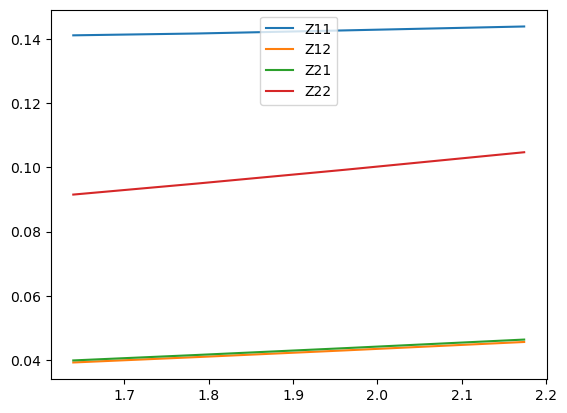

0.019680973862765766
0.11296850848549109
0.0314177579120416
3.5368587569690176e-13
2.0424902916589296e-13
2.945717720059121e-13


In [27]:
def extrinsic_resistances(measurements, open, Vth, plot=False):
    # Since we have to average the S-paramaters on a range of around 10GHz, we will choose arbitrarily (not too high in freq though)
    
    data = mdm_reader_extract(measurements) # data[i] is the i'th block of the file
    len_data = len(data)
    len_col = len(data[0])

    freq = data[0][:, 0]
    deltaf = (freq[1]-freq[0])*1e-9
    numfreq = int(10/deltaf)

    # For the resistances, we only work with a slice of the frequencies (10GHz band)
    freq_slice = freq[numfreq:numfreq*2]

    Vg = np.zeros(len_data)

    Z11, Z12, Z21, Z22 = deEmbedding(measurements, open)

    Z11_mean, Z12_mean, Z21_mean, Z22_mean = [np.zeros(len_data, dtype='complex') for _ in range(4)]
    
    # we iterate on each bias point
    for i in range(len_data):
        Z11_mean[i] = np.mean(Z11[i][numfreq:numfreq*2])
        Z12_mean[i] = np.mean(Z12[i][numfreq:numfreq*2])
        Z21_mean[i] = np.mean(Z21[i][numfreq:numfreq*2])
        Z22_mean[i] = np.mean(Z22[i][numfreq:numfreq*2])
        
        dummy, info = mdm_reader_index(measurements, i)
        Vg[i] = float(info[1].split()[-1])
    
    # We only keep the last 4 indices
    Vg = Vg[-4:]
    Z11_mean = Z11_mean[-4:]
    Z12_mean = Z12_mean[-4:]
    Z21_mean = Z21_mean[-4:]
    Z22_mean = Z22_mean[-4:]

    if plot:
        plt.plot(1/(Vg-Vth), np.real(Z11_mean), label='Z11')
        plt.plot(1/(Vg-Vth), np.real(Z12_mean), label='Z12')
        plt.plot(1/(Vg-Vth), np.real(Z21_mean), label='Z21')
        plt.plot(1/(Vg-Vth), np.real(Z22_mean), label='Z22')

        plt.legend()
        plt.show()

    # Extrapolation the curves at 0 (only the real part, to find resistances)
    dzdv11 = (np.real(Z11_mean[-1]) - np.real(Z11_mean[0])) / (1/(Vg[-1]-Vth) - 1/(Vg[0]-Vth))
    dzdv12 = (np.real(Z12_mean[-1]) - np.real(Z12_mean[0])) / (1/(Vg[-1]-Vth) - 1/(Vg[0]-Vth))
    dzdv21 = (np.real(Z21_mean[-1]) - np.real(Z21_mean[0])) / (1/(Vg[-1]-Vth) - 1/(Vg[0]-Vth))
    dzdv22 = (np.real(Z22_mean[-1]) - np.real(Z22_mean[0])) / (1/(Vg[-1]-Vth) - 1/(Vg[0]-Vth))    

    Z11_interp = np.real(Z11_mean[0]) - dzdv11 * 1/(Vg[0]-Vth)
    Z12_interp = np.real(Z12_mean[0]) - dzdv12 * 1/(Vg[0]-Vth)
    Z21_interp = np.real(Z21_mean[0]) - dzdv21 * 1/(Vg[0]-Vth)
    Z22_interp = np.real(Z22_mean[0]) - dzdv22 * 1/(Vg[0]-Vth)

    # System of equation
    Rse = Z12_interp
    Rge = Z11_interp - Rse
    Rde = Z22_interp - Rse


    # Extraction of the capacitances at Vg < 0 (deep depletion)
    # We start by retrieving the Z-matrix of the device by substracting the Zseries-matrix (Zinterp)
    for i in range(len_data):
        Z11 -= Z11_interp
        Z12 -= Z12_interp
        Z21 -= Z21_interp
        Z22 -= Z22_interp

    Y11, Y12, Y21, Y22 = [np.zeros_like(Z11) for _ in range(4)]
    for i in range(len_data):
        for j in range(len_col):
            Y = np.linalg.inv(np.array([[Z11[i][j], Z12[i][j]], [Z21[i][j], Z22[i][j]]]))
            Y11[i][j], Y12[i][j], Y21[i][j], Y22[i][j] = np.matrix.flatten(Y)
    
    # Only Y[0] interests us because we want Vg < 0. dd for deep depletion
    # We need to work at a specific frequency ! 

    Y11dd = Y11[0][numfreq*2]
    Y12dd = Y12[0][numfreq*2]
    Y21dd = Y21[0][numfreq*2]
    Y22dd = Y22[0][numfreq*2]

    f_capa = freq[numfreq*5]
    w_capa = 2*np.pi*f_capa

    Cgse = np.imag(Y11dd+Y12dd) / w_capa
    Cdse = np.imag(Y22dd+Y12dd) / w_capa
    Cgde = -np.imag(Y12dd) / w_capa

    return Rse, Rge, Rde, Cgse, Cdse, Cgde 


Rse, Rge, Rde, Cgse, Cdse, Cgde = extrinsic_resistances(measurements, open_measurements, 0.29, plot=True)

print(Rse)
print(Rge)
print(Rde)
print(Cgse)
print(Cdse)
print(Cgde)